In [1]:
!nvidia-smi

Tue Oct 10 01:19:27 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.67                 Driver Version: 536.67       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   47C    P4              39W / 131W |   2668MiB /  6141MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import numpy as np
from torch import nn
from torch.nn import functional as F
import torch
from torch import optim
from torchvision import datasets,transforms
from torchinfo import summary

In [3]:
from transformations import train_transforms,test_transforms

In [4]:
from trainer import Trainer
from tester import Tester
from utlis import visualize_data,show_misclassified_images,device,is_cuda
from viz import plot_class_distribution, plot_confusion_matrix, plot_curves
from dataloader import CIFAR10Dataset,CIFAR10DataLoader
from models import ConvLayer,TransBlock,DepthwiseConvLayer

In [5]:
# ALbumentation
train_dataset = CIFAR10Dataset(root='../data/',train=True,Atransforms=train_transforms,download=False)
test_dataset  = CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)

cifar = CIFAR10DataLoader()
train_loader,test_loader = cifar.get_loader(train_dataset,test_dataset)

In [6]:
cifar = CIFAR10DataLoader()
simple_train_loader , simple_test_loader = cifar.get_loader(
    CIFAR10Dataset(root='../data/',train=True,Atransforms=test_transforms,download=False),
    CIFAR10Dataset(root='../data/',train=False,Atransforms=test_transforms,download=False)
)

# Model

**Objective**
- squeeze expand structure from last session
- rf 44<
- not care about 200k
- 50 epoch
- no augmentation 
**Results**

In [7]:
# We used this Squeeze-Expand Network before
class Net1(nn.Module):
    def __init__(self):
        super(Net1,self).__init__()
        self.dp_rate = 0.2

        self.conv1 = nn.Sequential(
            ConvLayer(inc=3,outc=8,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=8,outc=24,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=24,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
        )
        self.trans1 = TransBlock(32,24)
        self.conv2 = nn.Sequential(
            ConvLayer(inc=24,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
        )
        self.trans2 = TransBlock(64,32)
        self.conv3 = nn.Sequential(
            ConvLayer(inc=32,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=64,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=64,outc=128,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
        )
        self.trans3 = TransBlock(128,64)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=1,bias=False,)
        )
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Conv2d(128,10,kernel_size=1,bias=False)
    def forward(self,x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.trans3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = self.out(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [8]:
simple_model = Net1().to(device)
# summary(simple_model,(3,32,32))

In [9]:
prev_test_loss = float('inf')

optimizer = optim.SGD(simple_model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(simple_model, simple_train_loader, optimizer, criterion, device)
tester = Tester(simple_model, simple_test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(simple_model.state_dict(),'./bmodels/simple_model_with_mp_rf44.pth')
    scheduler.step(test_loss)


EPOCH = 1 | LR = 0.2 | Loss = 1.78 | Batch = 390 | Accuracy = 23.46: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:25<00:00, 15.46it/s]


Test set: Average loss: 0.0146, Accuracy: 2935/10000 (29.35%)


EPOCH = 2 | LR = 0.2 | Loss = 1.78 | Batch = 390 | Accuracy = 32.42: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.20it/s]


Test set: Average loss: 0.0128, Accuracy: 4031/10000 (40.31%)


EPOCH = 3 | LR = 0.2 | Loss = 1.53 | Batch = 390 | Accuracy = 36.77: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.71it/s]


Test set: Average loss: 0.0126, Accuracy: 4155/10000 (41.55%)


EPOCH = 4 | LR = 0.2 | Loss = 1.53 | Batch = 390 | Accuracy = 39.64: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.33it/s]


Test set: Average loss: 0.0118, Accuracy: 4471/10000 (44.71%)


EPOCH = 5 | LR = 0.2 | Loss = 1.66 | Batch = 390 | Accuracy = 42.05: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.55it/s]


Test set: Average loss: 0.0119, Accuracy: 4517/10000 (45.17%)


EPOCH = 6 | LR = 0.2 | Loss = 1.42 | Batch = 390 | Accuracy = 44.94: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.10it/s]


Test set: Average loss: 0.0106, Accuracy: 5104/10000 (51.04%)


EPOCH = 7 | LR = 0.2 | Loss = 1.57 | Batch = 390 | Accuracy = 46.50: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.82it/s]


Test set: Average loss: 0.0107, Accuracy: 5080/10000 (50.80%)


EPOCH = 8 | LR = 0.2 | Loss = 1.35 | Batch = 390 | Accuracy = 49.47: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.39it/s]


Test set: Average loss: 0.0097, Accuracy: 5672/10000 (56.72%)


EPOCH = 9 | LR = 0.2 | Loss = 1.14 | Batch = 390 | Accuracy = 50.94: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.14it/s]


Test set: Average loss: 0.0092, Accuracy: 5746/10000 (57.46%)


EPOCH = 10 | LR = 0.2 | Loss = 1.33 | Batch = 390 | Accuracy = 53.62: 100%|████████████████████████████████████████████████████████████| 391/391 [00:16<00:00, 24.34it/s]


Test set: Average loss: 0.0088, Accuracy: 6095/10000 (60.95%)


EPOCH = 11 | LR = 0.2 | Loss = 1.01 | Batch = 390 | Accuracy = 55.22: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.28it/s]


Test set: Average loss: 0.0091, Accuracy: 5949/10000 (59.49%)


EPOCH = 12 | LR = 0.2 | Loss = 1.11 | Batch = 390 | Accuracy = 56.27: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.86it/s]


Test set: Average loss: 0.0085, Accuracy: 6200/10000 (62.00%)


EPOCH = 13 | LR = 0.2 | Loss = 1.21 | Batch = 390 | Accuracy = 57.70: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.91it/s]


Test set: Average loss: 0.0081, Accuracy: 6447/10000 (64.47%)


EPOCH = 14 | LR = 0.2 | Loss = 1.13 | Batch = 390 | Accuracy = 59.00: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.74it/s]


Test set: Average loss: 0.0081, Accuracy: 6366/10000 (63.66%)


EPOCH = 15 | LR = 0.2 | Loss = 0.90 | Batch = 390 | Accuracy = 60.34: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.00it/s]


Test set: Average loss: 0.0078, Accuracy: 6581/10000 (65.81%)


EPOCH = 16 | LR = 0.2 | Loss = 1.37 | Batch = 390 | Accuracy = 60.80: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.28it/s]


Test set: Average loss: 0.0081, Accuracy: 6465/10000 (64.65%)


EPOCH = 17 | LR = 0.2 | Loss = 1.18 | Batch = 390 | Accuracy = 61.84: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.85it/s]


Test set: Average loss: 0.0080, Accuracy: 6426/10000 (64.26%)


EPOCH = 18 | LR = 0.2 | Loss = 1.02 | Batch = 390 | Accuracy = 62.47: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.40it/s]


Test set: Average loss: 0.0075, Accuracy: 6670/10000 (66.70%)


EPOCH = 19 | LR = 0.2 | Loss = 0.81 | Batch = 390 | Accuracy = 63.42: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 24.91it/s]


Test set: Average loss: 0.0073, Accuracy: 6768/10000 (67.68%)


EPOCH = 20 | LR = 0.2 | Loss = 0.95 | Batch = 390 | Accuracy = 63.80: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 26.01it/s]


Test set: Average loss: 0.0077, Accuracy: 6610/10000 (66.10%)


EPOCH = 21 | LR = 0.2 | Loss = 1.10 | Batch = 390 | Accuracy = 64.30: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.88it/s]


Test set: Average loss: 0.0071, Accuracy: 6852/10000 (68.52%)


EPOCH = 22 | LR = 0.2 | Loss = 0.91 | Batch = 390 | Accuracy = 64.97: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.59it/s]


Test set: Average loss: 0.0066, Accuracy: 7089/10000 (70.89%)


EPOCH = 23 | LR = 0.2 | Loss = 0.90 | Batch = 390 | Accuracy = 65.52: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.84it/s]


Test set: Average loss: 0.0069, Accuracy: 6989/10000 (69.89%)


EPOCH = 24 | LR = 0.2 | Loss = 1.12 | Batch = 390 | Accuracy = 65.82: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 27.15it/s]


Test set: Average loss: 0.0065, Accuracy: 7149/10000 (71.49%)


EPOCH = 25 | LR = 0.2 | Loss = 0.91 | Batch = 390 | Accuracy = 66.77: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.56it/s]


Test set: Average loss: 0.0071, Accuracy: 6915/10000 (69.15%)


EPOCH = 26 | LR = 0.2 | Loss = 0.89 | Batch = 390 | Accuracy = 66.94: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.20it/s]


Test set: Average loss: 0.0062, Accuracy: 7270/10000 (72.70%)


EPOCH = 27 | LR = 0.2 | Loss = 0.98 | Batch = 390 | Accuracy = 67.31: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.80it/s]


Test set: Average loss: 0.0063, Accuracy: 7262/10000 (72.62%)


EPOCH = 28 | LR = 0.2 | Loss = 1.11 | Batch = 390 | Accuracy = 67.84: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.63it/s]


Test set: Average loss: 0.0067, Accuracy: 7077/10000 (70.77%)


EPOCH = 29 | LR = 0.2 | Loss = 0.81 | Batch = 390 | Accuracy = 68.04: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.71it/s]


Test set: Average loss: 0.0061, Accuracy: 7307/10000 (73.07%)


EPOCH = 30 | LR = 0.2 | Loss = 0.86 | Batch = 390 | Accuracy = 68.69: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.92it/s]


Test set: Average loss: 0.0060, Accuracy: 7313/10000 (73.13%)


EPOCH = 31 | LR = 0.2 | Loss = 0.89 | Batch = 390 | Accuracy = 68.62: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.67it/s]


Test set: Average loss: 0.0061, Accuracy: 7269/10000 (72.69%)


EPOCH = 32 | LR = 0.2 | Loss = 1.11 | Batch = 390 | Accuracy = 69.01: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.47it/s]


Test set: Average loss: 0.0061, Accuracy: 7351/10000 (73.51%)


EPOCH = 33 | LR = 0.2 | Loss = 0.95 | Batch = 390 | Accuracy = 69.47: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.15it/s]


Test set: Average loss: 0.0058, Accuracy: 7507/10000 (75.07%)


EPOCH = 34 | LR = 0.2 | Loss = 1.01 | Batch = 390 | Accuracy = 69.86: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.80it/s]


Test set: Average loss: 0.0060, Accuracy: 7329/10000 (73.29%)


EPOCH = 35 | LR = 0.2 | Loss = 0.86 | Batch = 390 | Accuracy = 70.10: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.10it/s]


Test set: Average loss: 0.0059, Accuracy: 7444/10000 (74.44%)


EPOCH = 36 | LR = 0.2 | Loss = 1.14 | Batch = 390 | Accuracy = 70.55: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.30it/s]


Test set: Average loss: 0.0056, Accuracy: 7583/10000 (75.83%)


EPOCH = 37 | LR = 0.2 | Loss = 0.84 | Batch = 390 | Accuracy = 70.66: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.54it/s]


Test set: Average loss: 0.0060, Accuracy: 7364/10000 (73.64%)


EPOCH = 38 | LR = 0.2 | Loss = 1.08 | Batch = 390 | Accuracy = 70.69: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.40it/s]


Test set: Average loss: 0.0055, Accuracy: 7572/10000 (75.72%)


EPOCH = 39 | LR = 0.2 | Loss = 0.67 | Batch = 390 | Accuracy = 71.01: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.91it/s]


Test set: Average loss: 0.0060, Accuracy: 7396/10000 (73.96%)


EPOCH = 40 | LR = 0.2 | Loss = 0.75 | Batch = 390 | Accuracy = 71.05: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.07it/s]


Test set: Average loss: 0.0056, Accuracy: 7525/10000 (75.25%)


EPOCH = 41 | LR = 0.2 | Loss = 0.72 | Batch = 390 | Accuracy = 71.94: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.90it/s]


Test set: Average loss: 0.0057, Accuracy: 7494/10000 (74.94%)


EPOCH = 42 | LR = 0.2 | Loss = 0.86 | Batch = 390 | Accuracy = 71.64: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.42it/s]


Test set: Average loss: 0.0056, Accuracy: 7483/10000 (74.83%)


EPOCH = 43 | LR = 0.2 | Loss = 0.65 | Batch = 390 | Accuracy = 72.01: 100%|████████████████████████████████████████████████████████████| 391/391 [00:14<00:00, 26.21it/s]


Test set: Average loss: 0.0058, Accuracy: 7492/10000 (74.92%)


EPOCH = 44 | LR = 0.2 | Loss = 0.83 | Batch = 390 | Accuracy = 72.46: 100%|████████████████████████████████████████████████████████████| 391/391 [00:15<00:00, 25.91it/s]


Test set: Average loss: 0.0057, Accuracy: 7445/10000 (74.45%)


EPOCH = 45 | LR = 0.020000000000000004 | Loss = 0.59 | Batch = 390 | Accuracy = 74.60: 100%|███████████████████████████████████████████| 391/391 [00:14<00:00, 26.36it/s]


Test set: Average loss: 0.0052, Accuracy: 7745/10000 (77.45%)


EPOCH = 46 | LR = 0.020000000000000004 | Loss = 0.63 | Batch = 390 | Accuracy = 75.48: 100%|███████████████████████████████████████████| 391/391 [00:15<00:00, 25.58it/s]


Test set: Average loss: 0.0051, Accuracy: 7818/10000 (78.18%)


EPOCH = 47 | LR = 0.020000000000000004 | Loss = 0.63 | Batch = 390 | Accuracy = 75.70: 100%|███████████████████████████████████████████| 391/391 [00:15<00:00, 25.83it/s]


Test set: Average loss: 0.0052, Accuracy: 7789/10000 (77.89%)


EPOCH = 48 | LR = 0.020000000000000004 | Loss = 0.69 | Batch = 390 | Accuracy = 75.85: 100%|███████████████████████████████████████████| 391/391 [00:14<00:00, 26.16it/s]


Test set: Average loss: 0.0052, Accuracy: 7722/10000 (77.22%)


EPOCH = 49 | LR = 0.020000000000000004 | Loss = 0.64 | Batch = 390 | Accuracy = 75.83: 100%|███████████████████████████████████████████| 391/391 [00:14<00:00, 26.28it/s]


Test set: Average loss: 0.0051, Accuracy: 7800/10000 (78.00%)


EPOCH = 50 | LR = 0.020000000000000004 | Loss = 0.69 | Batch = 390 | Accuracy = 75.97: 100%|███████████████████████████████████████████| 391/391 [00:14<00:00, 26.39it/s]


Test set: Average loss: 0.0050, Accuracy: 7832/10000 (78.32%)


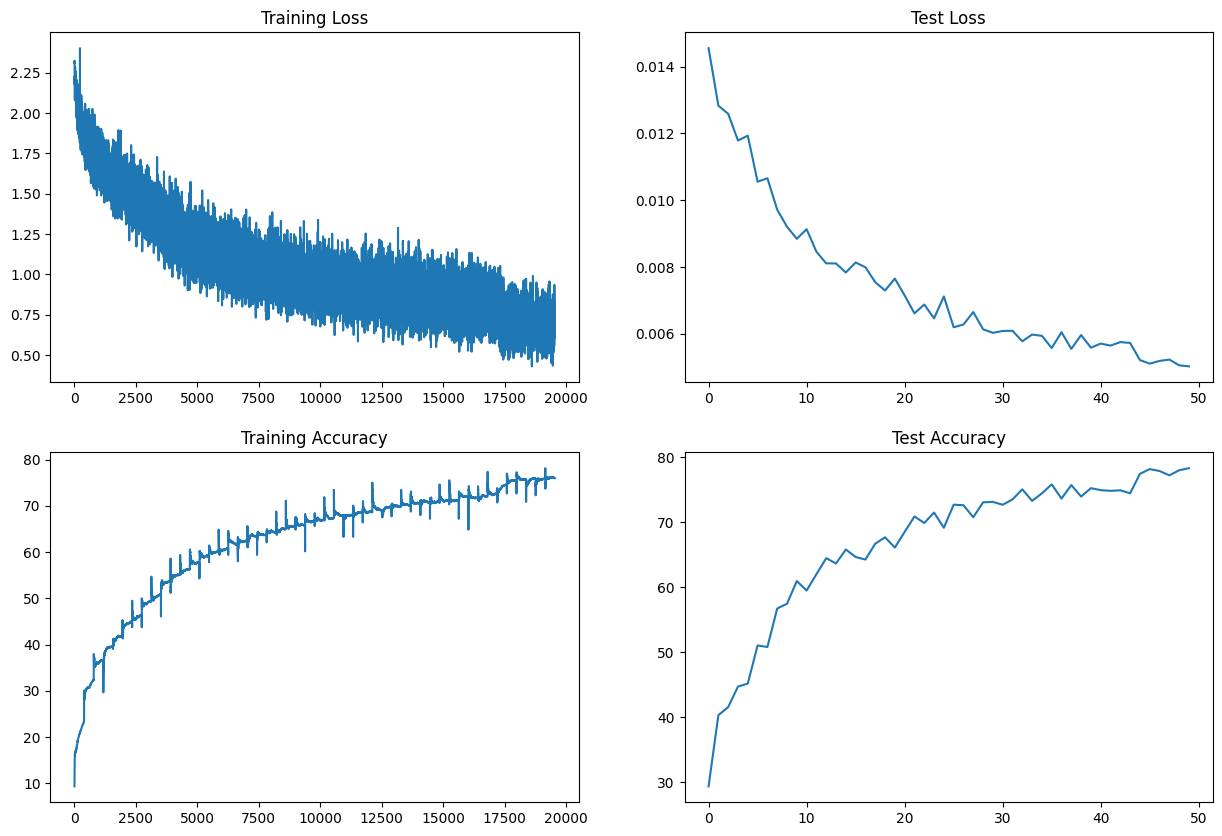

In [10]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Model-1 with Augmentation

In [11]:
prev_test_loss = float('inf')
simple_model = Net1().to(device)
optimizer = optim.SGD(simple_model.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(simple_model, train_loader, optimizer, criterion, device)
tester = Tester(simple_model, test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(simple_model.state_dict(),'./bmodels/simple_model_with_mp_rf44_aug.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.2 | Loss = 2.05 | Batch = 390 | Accuracy = 21.75: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.75it/s]


Test set: Average loss: 0.0156, Accuracy: 2677/10000 (26.77%)


EPOCH = 2 | LR = 0.2 | Loss = 2.02 | Batch = 390 | Accuracy = 27.17: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.93it/s]


Test set: Average loss: 0.0143, Accuracy: 3467/10000 (34.67%)


EPOCH = 3 | LR = 0.2 | Loss = 2.09 | Batch = 390 | Accuracy = 30.25: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.38it/s]


Test set: Average loss: 0.0132, Accuracy: 3837/10000 (38.37%)


EPOCH = 4 | LR = 0.2 | Loss = 1.91 | Batch = 390 | Accuracy = 31.93: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.54it/s]


Test set: Average loss: 0.0131, Accuracy: 3789/10000 (37.89%)


EPOCH = 5 | LR = 0.2 | Loss = 1.73 | Batch = 390 | Accuracy = 33.71: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.61it/s]


Test set: Average loss: 0.0124, Accuracy: 4290/10000 (42.90%)


EPOCH = 6 | LR = 0.2 | Loss = 1.62 | Batch = 390 | Accuracy = 34.86: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.42it/s]


Test set: Average loss: 0.0120, Accuracy: 4273/10000 (42.73%)


EPOCH = 7 | LR = 0.2 | Loss = 1.60 | Batch = 390 | Accuracy = 36.53: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.28it/s]


Test set: Average loss: 0.0115, Accuracy: 4576/10000 (45.76%)


EPOCH = 8 | LR = 0.2 | Loss = 1.73 | Batch = 390 | Accuracy = 37.33: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:17<00:00, 21.73it/s]


Test set: Average loss: 0.0114, Accuracy: 4608/10000 (46.08%)


EPOCH = 9 | LR = 0.2 | Loss = 1.73 | Batch = 390 | Accuracy = 38.13: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.49it/s]


Test set: Average loss: 0.0111, Accuracy: 4790/10000 (47.90%)


EPOCH = 10 | LR = 0.2 | Loss = 1.62 | Batch = 390 | Accuracy = 39.57: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.48it/s]


Test set: Average loss: 0.0111, Accuracy: 4764/10000 (47.64%)


EPOCH = 11 | LR = 0.2 | Loss = 1.67 | Batch = 390 | Accuracy = 40.32: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.35it/s]


Test set: Average loss: 0.0107, Accuracy: 5096/10000 (50.96%)


EPOCH = 12 | LR = 0.2 | Loss = 1.71 | Batch = 390 | Accuracy = 41.17: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.23it/s]


Test set: Average loss: 0.0105, Accuracy: 4982/10000 (49.82%)


EPOCH = 13 | LR = 0.2 | Loss = 1.68 | Batch = 390 | Accuracy = 42.47: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.45it/s]


Test set: Average loss: 0.0102, Accuracy: 5193/10000 (51.93%)


EPOCH = 14 | LR = 0.2 | Loss = 1.60 | Batch = 390 | Accuracy = 43.20: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.34it/s]


Test set: Average loss: 0.0100, Accuracy: 5309/10000 (53.09%)


EPOCH = 15 | LR = 0.2 | Loss = 1.56 | Batch = 390 | Accuracy = 43.63: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.45it/s]


Test set: Average loss: 0.0098, Accuracy: 5439/10000 (54.39%)


EPOCH = 16 | LR = 0.2 | Loss = 1.60 | Batch = 390 | Accuracy = 44.74: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.29it/s]


Test set: Average loss: 0.0096, Accuracy: 5623/10000 (56.23%)


EPOCH = 17 | LR = 0.2 | Loss = 1.52 | Batch = 390 | Accuracy = 45.20: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.17it/s]


Test set: Average loss: 0.0097, Accuracy: 5568/10000 (55.68%)


EPOCH = 18 | LR = 0.2 | Loss = 1.39 | Batch = 390 | Accuracy = 45.51: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.70it/s]


Test set: Average loss: 0.0090, Accuracy: 5905/10000 (59.05%)


EPOCH = 19 | LR = 0.2 | Loss = 1.49 | Batch = 390 | Accuracy = 46.01: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.67it/s]


Test set: Average loss: 0.0096, Accuracy: 5689/10000 (56.89%)


EPOCH = 20 | LR = 0.2 | Loss = 1.45 | Batch = 390 | Accuracy = 47.09: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.39it/s]


Test set: Average loss: 0.0090, Accuracy: 5911/10000 (59.11%)


EPOCH = 21 | LR = 0.2 | Loss = 1.33 | Batch = 390 | Accuracy = 47.37: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.67it/s]


Test set: Average loss: 0.0091, Accuracy: 5869/10000 (58.69%)


EPOCH = 22 | LR = 0.2 | Loss = 1.28 | Batch = 390 | Accuracy = 47.41: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.05it/s]


Test set: Average loss: 0.0088, Accuracy: 6059/10000 (60.59%)


EPOCH = 23 | LR = 0.2 | Loss = 1.37 | Batch = 390 | Accuracy = 47.76: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.31it/s]


Test set: Average loss: 0.0093, Accuracy: 5877/10000 (58.77%)


EPOCH = 24 | LR = 0.2 | Loss = 1.34 | Batch = 390 | Accuracy = 48.53: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.97it/s]


Test set: Average loss: 0.0092, Accuracy: 5859/10000 (58.59%)


EPOCH = 25 | LR = 0.2 | Loss = 1.43 | Batch = 390 | Accuracy = 48.91: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.85it/s]


Test set: Average loss: 0.0084, Accuracy: 6219/10000 (62.19%)


EPOCH = 26 | LR = 0.2 | Loss = 1.40 | Batch = 390 | Accuracy = 49.10: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.89it/s]


Test set: Average loss: 0.0084, Accuracy: 6251/10000 (62.51%)


EPOCH = 27 | LR = 0.2 | Loss = 1.48 | Batch = 390 | Accuracy = 49.52: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.17it/s]


Test set: Average loss: 0.0086, Accuracy: 6116/10000 (61.16%)


EPOCH = 28 | LR = 0.2 | Loss = 1.52 | Batch = 390 | Accuracy = 49.83: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.36it/s]


Test set: Average loss: 0.0083, Accuracy: 6280/10000 (62.80%)


EPOCH = 29 | LR = 0.2 | Loss = 1.49 | Batch = 390 | Accuracy = 50.00: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.68it/s]


Test set: Average loss: 0.0082, Accuracy: 6266/10000 (62.66%)


EPOCH = 30 | LR = 0.2 | Loss = 1.33 | Batch = 390 | Accuracy = 50.52: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.21it/s]


Test set: Average loss: 0.0081, Accuracy: 6362/10000 (63.62%)


EPOCH = 31 | LR = 0.2 | Loss = 1.27 | Batch = 390 | Accuracy = 50.61: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.71it/s]


Test set: Average loss: 0.0082, Accuracy: 6314/10000 (63.14%)


EPOCH = 32 | LR = 0.2 | Loss = 1.46 | Batch = 390 | Accuracy = 50.97: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.95it/s]


Test set: Average loss: 0.0081, Accuracy: 6420/10000 (64.20%)


EPOCH = 33 | LR = 0.2 | Loss = 1.20 | Batch = 390 | Accuracy = 51.19: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.25it/s]


Test set: Average loss: 0.0082, Accuracy: 6302/10000 (63.02%)


EPOCH = 34 | LR = 0.2 | Loss = 1.15 | Batch = 390 | Accuracy = 51.27: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.76it/s]


Test set: Average loss: 0.0079, Accuracy: 6471/10000 (64.71%)


EPOCH = 35 | LR = 0.2 | Loss = 1.33 | Batch = 390 | Accuracy = 51.66: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.92it/s]


Test set: Average loss: 0.0078, Accuracy: 6481/10000 (64.81%)


EPOCH = 36 | LR = 0.2 | Loss = 1.19 | Batch = 390 | Accuracy = 51.88: 100%|████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.51it/s]


Test set: Average loss: 0.0077, Accuracy: 6583/10000 (65.83%)


EPOCH = 37 | LR = 0.2 | Loss = 1.42 | Batch = 390 | Accuracy = 52.16: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.32it/s]


Test set: Average loss: 0.0081, Accuracy: 6357/10000 (63.57%)


EPOCH = 38 | LR = 0.2 | Loss = 1.47 | Batch = 390 | Accuracy = 52.52: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.77it/s]


Test set: Average loss: 0.0081, Accuracy: 6365/10000 (63.65%)


EPOCH = 39 | LR = 0.2 | Loss = 1.54 | Batch = 390 | Accuracy = 52.83: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.95it/s]


Test set: Average loss: 0.0081, Accuracy: 6318/10000 (63.18%)


EPOCH = 40 | LR = 0.2 | Loss = 1.45 | Batch = 390 | Accuracy = 52.43: 100%|████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.57it/s]


Test set: Average loss: 0.0075, Accuracy: 6640/10000 (66.40%)


EPOCH = 41 | LR = 0.2 | Loss = 1.46 | Batch = 390 | Accuracy = 52.58: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.83it/s]


Test set: Average loss: 0.0078, Accuracy: 6485/10000 (64.85%)


EPOCH = 42 | LR = 0.2 | Loss = 1.31 | Batch = 390 | Accuracy = 52.68: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.75it/s]


Test set: Average loss: 0.0079, Accuracy: 6456/10000 (64.56%)


EPOCH = 43 | LR = 0.2 | Loss = 1.44 | Batch = 390 | Accuracy = 53.15: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 20.95it/s]


Test set: Average loss: 0.0077, Accuracy: 6597/10000 (65.97%)


EPOCH = 44 | LR = 0.2 | Loss = 1.32 | Batch = 390 | Accuracy = 53.32: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.25it/s]


Test set: Average loss: 0.0075, Accuracy: 6655/10000 (66.55%)


EPOCH = 45 | LR = 0.2 | Loss = 1.35 | Batch = 390 | Accuracy = 53.31: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.26it/s]


Test set: Average loss: 0.0079, Accuracy: 6504/10000 (65.04%)


EPOCH = 46 | LR = 0.2 | Loss = 1.10 | Batch = 390 | Accuracy = 53.52: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.13it/s]


Test set: Average loss: 0.0076, Accuracy: 6602/10000 (66.02%)


EPOCH = 47 | LR = 0.2 | Loss = 1.19 | Batch = 390 | Accuracy = 53.85: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.22it/s]


Test set: Average loss: 0.0081, Accuracy: 6530/10000 (65.30%)


EPOCH = 48 | LR = 0.2 | Loss = 1.27 | Batch = 390 | Accuracy = 53.69: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.32it/s]


Test set: Average loss: 0.0081, Accuracy: 6493/10000 (64.93%)


EPOCH = 49 | LR = 0.2 | Loss = 1.42 | Batch = 390 | Accuracy = 53.92: 100%|████████████████████████████████████████████████████████████| 391/391 [00:18<00:00, 21.08it/s]


Test set: Average loss: 0.0073, Accuracy: 6663/10000 (66.63%)


EPOCH = 50 | LR = 0.2 | Loss = 1.12 | Batch = 390 | Accuracy = 53.98: 100%|████████████████████████████████████████████████████████████| 391/391 [00:19<00:00, 20.35it/s]


Test set: Average loss: 0.0071, Accuracy: 6880/10000 (68.80%)


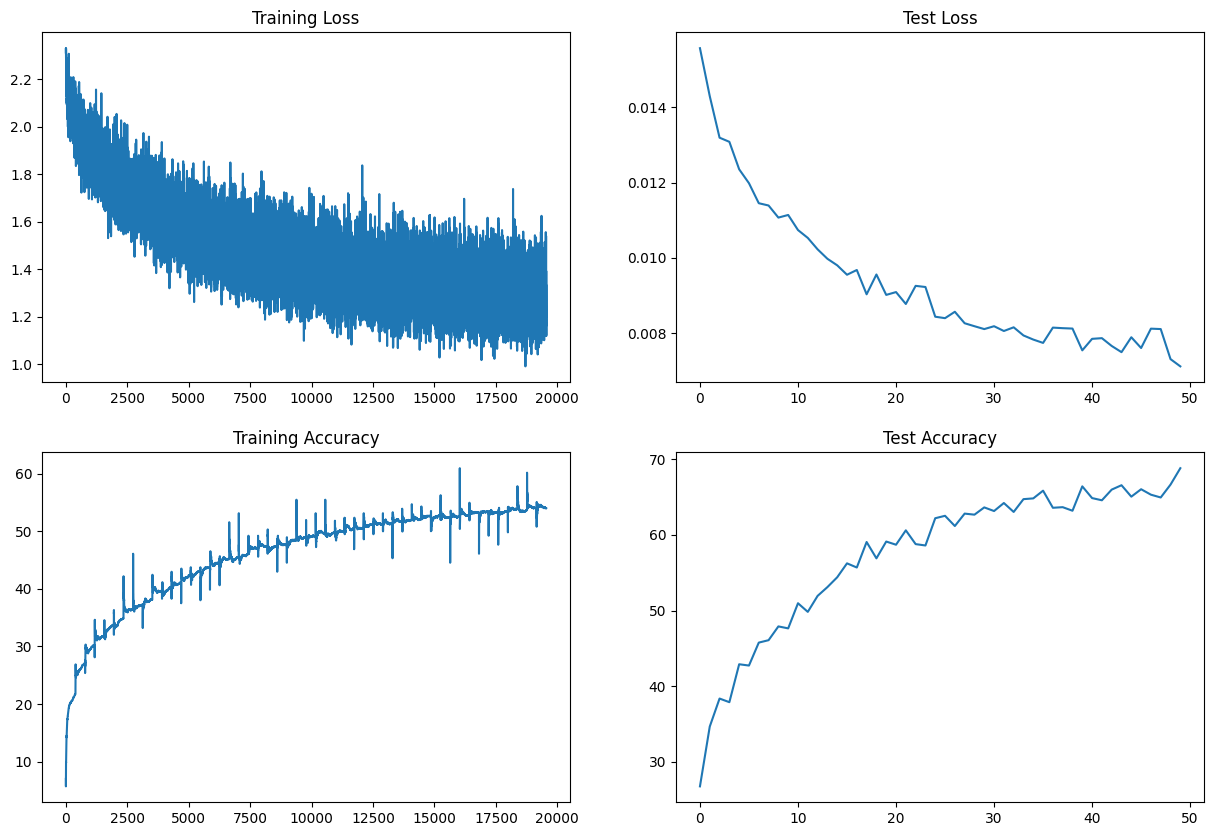

In [12]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Model-2

**Objective**
- remove MP
- use strided instead
- rest same as previous model

**Results**
-
-

In [13]:
# We used this Squeeze-Expand Network before
class Net2(nn.Module):
    def __init__(self,dp:int):
        super(Net2,self).__init__()
        self.dp_rate = dp

        self.conv1 = nn.Sequential(
            ConvLayer(inc=3,outc=8,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=8,outc=24,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=24,outc=32,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate),
        )
        # self.trans1 = TransBlock(32,24)
        self.trans1 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=24,kernel_size=1,bias=False)
        )
        self.conv2 = nn.Sequential(
            ConvLayer(inc=24,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=32,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=32,outc=64,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate),
        )
        # self.trans2 = TransBlock(64,32)
        self.trans2 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=1,bias=False)
        )
        
        self.conv3 = nn.Sequential(
            ConvLayer(inc=32,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=64,outc=64,k=3,s=1,p=1,d=1,dp_rate=self.dp_rate),
            ConvLayer(inc=64,outc=128,k=3,s=2,p=1,d=1,dp_rate=self.dp_rate),
        )
        # self.trans3 = TransBlock(128,64)
        self.trans3 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=64,kernel_size=1,bias=False)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=1,bias=False,)
        )
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.out = nn.Conv2d(128,10,kernel_size=1,bias=False)
    def forward(self,x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        x = self.trans2(x)
        x = self.conv3(x)
        x = self.trans3(x)
        x = self.conv4(x)
        x = self.gap(x)
        x = self.out(x)
        return F.log_softmax(x.view(-1,10), dim=1)

In [14]:
model2_removed_mp = Net2(0.2).to(device)
# summary(model2_removed_mp,(3,32,32))

In [15]:
prev_test_loss = float('inf')

optimizer = optim.SGD(model2_removed_mp.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model2_removed_mp, simple_train_loader, optimizer, criterion, device)
tester = Tester(model2_removed_mp, simple_test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(simple_model.state_dict(),'./bmodels/model1_without_mp.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.2 | Loss = 1.78 | Batch = 390 | Accuracy = 22.65: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.91it/s]


Test set: Average loss: 0.0141, Accuracy: 3105/10000 (31.05%)


EPOCH = 2 | LR = 0.2 | Loss = 1.63 | Batch = 390 | Accuracy = 31.12: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 32.06it/s]


Test set: Average loss: 0.0136, Accuracy: 3482/10000 (34.82%)


EPOCH = 3 | LR = 0.2 | Loss = 1.63 | Batch = 390 | Accuracy = 35.47: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.99it/s]


Test set: Average loss: 0.0122, Accuracy: 4157/10000 (41.57%)


EPOCH = 4 | LR = 0.2 | Loss = 1.70 | Batch = 390 | Accuracy = 38.40: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.81it/s]


Test set: Average loss: 0.0122, Accuracy: 4242/10000 (42.42%)


EPOCH = 5 | LR = 0.2 | Loss = 1.41 | Batch = 390 | Accuracy = 39.98: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.79it/s]


Test set: Average loss: 0.0116, Accuracy: 4540/10000 (45.40%)


EPOCH = 6 | LR = 0.2 | Loss = 1.52 | Batch = 390 | Accuracy = 42.44: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.41it/s]


Test set: Average loss: 0.0116, Accuracy: 4690/10000 (46.90%)


EPOCH = 7 | LR = 0.2 | Loss = 1.44 | Batch = 390 | Accuracy = 44.61: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.83it/s]


Test set: Average loss: 0.0106, Accuracy: 5141/10000 (51.41%)


EPOCH = 8 | LR = 0.2 | Loss = 1.60 | Batch = 390 | Accuracy = 46.48: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.48it/s]


Test set: Average loss: 0.0102, Accuracy: 5278/10000 (52.78%)


EPOCH = 9 | LR = 0.2 | Loss = 1.50 | Batch = 390 | Accuracy = 48.21: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.47it/s]


Test set: Average loss: 0.0098, Accuracy: 5558/10000 (55.58%)


EPOCH = 10 | LR = 0.2 | Loss = 1.49 | Batch = 390 | Accuracy = 49.49: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.27it/s]


Test set: Average loss: 0.0094, Accuracy: 5767/10000 (57.67%)


EPOCH = 11 | LR = 0.2 | Loss = 1.38 | Batch = 390 | Accuracy = 51.43: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.72it/s]


Test set: Average loss: 0.0095, Accuracy: 5653/10000 (56.53%)


EPOCH = 12 | LR = 0.2 | Loss = 1.16 | Batch = 390 | Accuracy = 52.85: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.71it/s]


Test set: Average loss: 0.0089, Accuracy: 5870/10000 (58.70%)


EPOCH = 13 | LR = 0.2 | Loss = 1.34 | Batch = 390 | Accuracy = 54.19: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.57it/s]


Test set: Average loss: 0.0088, Accuracy: 6073/10000 (60.73%)


EPOCH = 14 | LR = 0.2 | Loss = 1.26 | Batch = 390 | Accuracy = 55.66: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.75it/s]


Test set: Average loss: 0.0085, Accuracy: 6254/10000 (62.54%)


EPOCH = 15 | LR = 0.2 | Loss = 1.15 | Batch = 390 | Accuracy = 56.62: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.70it/s]


Test set: Average loss: 0.0081, Accuracy: 6314/10000 (63.14%)


EPOCH = 16 | LR = 0.2 | Loss = 1.26 | Batch = 390 | Accuracy = 57.63: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.04it/s]


Test set: Average loss: 0.0078, Accuracy: 6562/10000 (65.62%)


EPOCH = 17 | LR = 0.2 | Loss = 1.23 | Batch = 390 | Accuracy = 58.91: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.05it/s]


Test set: Average loss: 0.0081, Accuracy: 6400/10000 (64.00%)


EPOCH = 18 | LR = 0.2 | Loss = 1.00 | Batch = 390 | Accuracy = 59.69: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.59it/s]


Test set: Average loss: 0.0076, Accuracy: 6611/10000 (66.11%)


EPOCH = 19 | LR = 0.2 | Loss = 1.18 | Batch = 390 | Accuracy = 60.23: 100%|████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 29.46it/s]


Test set: Average loss: 0.0075, Accuracy: 6645/10000 (66.45%)


EPOCH = 20 | LR = 0.2 | Loss = 1.05 | Batch = 390 | Accuracy = 60.72: 100%|████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 29.43it/s]


Test set: Average loss: 0.0077, Accuracy: 6585/10000 (65.85%)


EPOCH = 21 | LR = 0.2 | Loss = 1.18 | Batch = 390 | Accuracy = 61.72: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.67it/s]


Test set: Average loss: 0.0075, Accuracy: 6719/10000 (67.19%)


EPOCH = 22 | LR = 0.2 | Loss = 1.13 | Batch = 390 | Accuracy = 62.54: 100%|████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 29.20it/s]


Test set: Average loss: 0.0071, Accuracy: 6835/10000 (68.35%)


EPOCH = 23 | LR = 0.2 | Loss = 1.30 | Batch = 390 | Accuracy = 62.44: 100%|████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 30.04it/s]


Test set: Average loss: 0.0069, Accuracy: 6986/10000 (69.86%)


EPOCH = 24 | LR = 0.2 | Loss = 1.17 | Batch = 390 | Accuracy = 63.13: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.37it/s]


Test set: Average loss: 0.0070, Accuracy: 6836/10000 (68.36%)


EPOCH = 25 | LR = 0.2 | Loss = 1.25 | Batch = 390 | Accuracy = 63.57: 100%|████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 29.79it/s]


Test set: Average loss: 0.0070, Accuracy: 6950/10000 (69.50%)


EPOCH = 26 | LR = 0.2 | Loss = 1.20 | Batch = 390 | Accuracy = 64.39: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.01it/s]


Test set: Average loss: 0.0070, Accuracy: 6935/10000 (69.35%)


EPOCH = 27 | LR = 0.2 | Loss = 1.22 | Batch = 390 | Accuracy = 64.69: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.63it/s]


Test set: Average loss: 0.0066, Accuracy: 7025/10000 (70.25%)


EPOCH = 28 | LR = 0.2 | Loss = 1.14 | Batch = 390 | Accuracy = 65.08: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.13it/s]


Test set: Average loss: 0.0065, Accuracy: 7106/10000 (71.06%)


EPOCH = 29 | LR = 0.2 | Loss = 0.99 | Batch = 390 | Accuracy = 65.05: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.12it/s]


Test set: Average loss: 0.0066, Accuracy: 7078/10000 (70.78%)


EPOCH = 30 | LR = 0.2 | Loss = 0.79 | Batch = 390 | Accuracy = 65.23: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.64it/s]


Test set: Average loss: 0.0065, Accuracy: 7079/10000 (70.79%)


EPOCH = 31 | LR = 0.2 | Loss = 1.08 | Batch = 390 | Accuracy = 65.83: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.09it/s]


Test set: Average loss: 0.0067, Accuracy: 7055/10000 (70.55%)


EPOCH = 32 | LR = 0.2 | Loss = 1.10 | Batch = 390 | Accuracy = 66.16: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.89it/s]


Test set: Average loss: 0.0065, Accuracy: 7138/10000 (71.38%)


EPOCH = 33 | LR = 0.2 | Loss = 1.06 | Batch = 390 | Accuracy = 66.52: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.48it/s]


Test set: Average loss: 0.0064, Accuracy: 7193/10000 (71.93%)


EPOCH = 34 | LR = 0.2 | Loss = 0.76 | Batch = 390 | Accuracy = 66.61: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.96it/s]


Test set: Average loss: 0.0066, Accuracy: 7099/10000 (70.99%)


EPOCH = 35 | LR = 0.2 | Loss = 0.83 | Batch = 390 | Accuracy = 66.96: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.27it/s]


Test set: Average loss: 0.0064, Accuracy: 7163/10000 (71.63%)


EPOCH = 36 | LR = 0.2 | Loss = 0.98 | Batch = 390 | Accuracy = 67.33: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.69it/s]


Test set: Average loss: 0.0065, Accuracy: 7115/10000 (71.15%)


EPOCH = 37 | LR = 0.2 | Loss = 0.77 | Batch = 390 | Accuracy = 67.74: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.80it/s]


Test set: Average loss: 0.0061, Accuracy: 7360/10000 (73.60%)


EPOCH = 38 | LR = 0.2 | Loss = 0.97 | Batch = 390 | Accuracy = 67.64: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.45it/s]


Test set: Average loss: 0.0062, Accuracy: 7236/10000 (72.36%)


EPOCH = 39 | LR = 0.2 | Loss = 0.89 | Batch = 390 | Accuracy = 67.88: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.47it/s]


Test set: Average loss: 0.0064, Accuracy: 7216/10000 (72.16%)


EPOCH = 40 | LR = 0.2 | Loss = 1.07 | Batch = 390 | Accuracy = 68.05: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.23it/s]


Test set: Average loss: 0.0063, Accuracy: 7286/10000 (72.86%)


EPOCH = 41 | LR = 0.2 | Loss = 1.12 | Batch = 390 | Accuracy = 68.28: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.00it/s]


Test set: Average loss: 0.0063, Accuracy: 7262/10000 (72.62%)


EPOCH = 42 | LR = 0.2 | Loss = 0.94 | Batch = 390 | Accuracy = 68.62: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.29it/s]


Test set: Average loss: 0.0060, Accuracy: 7458/10000 (74.58%)


EPOCH = 43 | LR = 0.2 | Loss = 0.89 | Batch = 390 | Accuracy = 68.69: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.20it/s]


Test set: Average loss: 0.0060, Accuracy: 7378/10000 (73.78%)


EPOCH = 44 | LR = 0.2 | Loss = 0.67 | Batch = 390 | Accuracy = 68.71: 100%|████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 29.97it/s]


Test set: Average loss: 0.0061, Accuracy: 7362/10000 (73.62%)


EPOCH = 45 | LR = 0.2 | Loss = 1.05 | Batch = 390 | Accuracy = 68.95: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.90it/s]


Test set: Average loss: 0.0062, Accuracy: 7286/10000 (72.86%)


EPOCH = 46 | LR = 0.2 | Loss = 0.94 | Batch = 390 | Accuracy = 68.94: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.87it/s]


Test set: Average loss: 0.0059, Accuracy: 7391/10000 (73.91%)


EPOCH = 47 | LR = 0.2 | Loss = 0.80 | Batch = 390 | Accuracy = 68.91: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.19it/s]


Test set: Average loss: 0.0060, Accuracy: 7380/10000 (73.80%)


EPOCH = 48 | LR = 0.2 | Loss = 0.75 | Batch = 390 | Accuracy = 69.36: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.85it/s]


Test set: Average loss: 0.0060, Accuracy: 7401/10000 (74.01%)


EPOCH = 49 | LR = 0.2 | Loss = 0.83 | Batch = 390 | Accuracy = 69.65: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.50it/s]


Test set: Average loss: 0.0058, Accuracy: 7438/10000 (74.38%)


EPOCH = 50 | LR = 0.2 | Loss = 0.83 | Batch = 390 | Accuracy = 69.72: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.00it/s]


Test set: Average loss: 0.0059, Accuracy: 7439/10000 (74.39%)


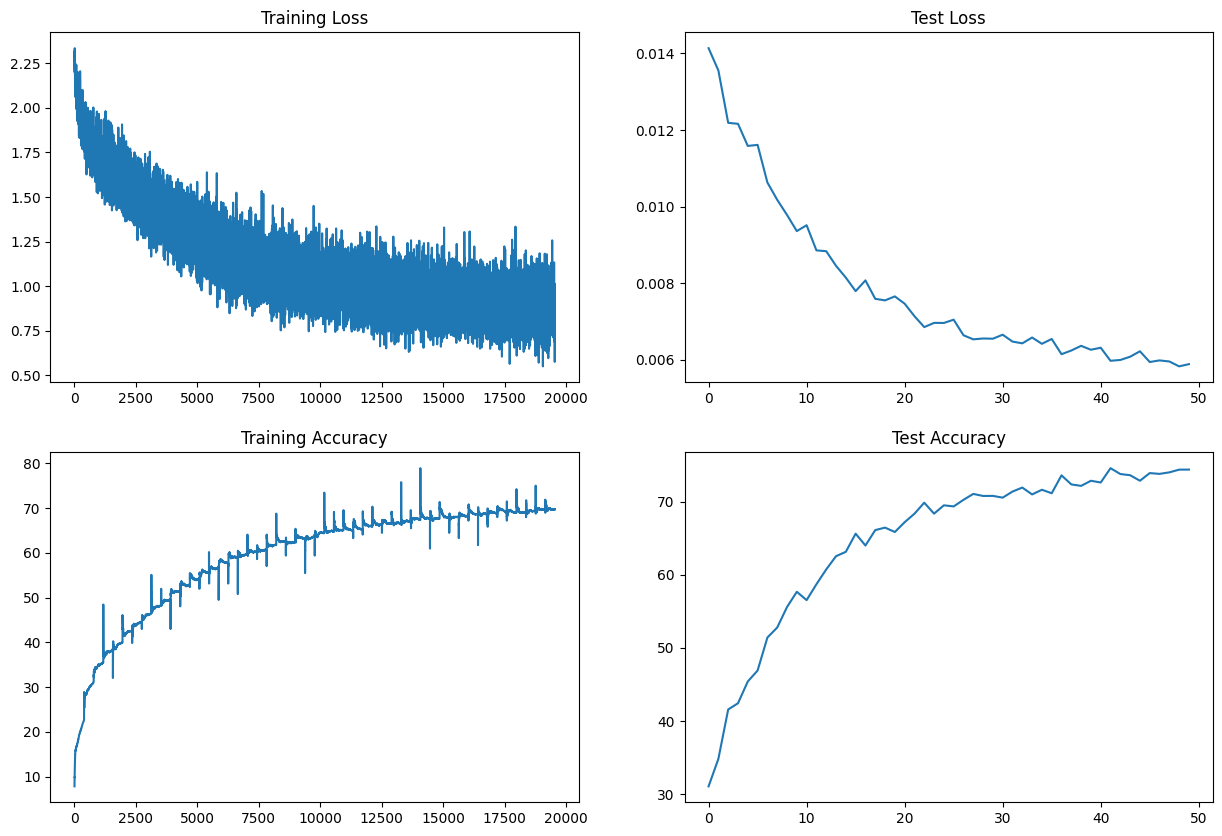

In [16]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Model-2 with AUG

In [17]:
prev_test_loss = float('inf')
model2_removed_mp = Net2(0.2).to(device)
optimizer = optim.SGD(model2_removed_mp.parameters(), lr=0.2, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,mode='min',factor=0.1,patience=5)
criterion = nn.NLLLoss()
trainer = Trainer(model2_removed_mp, simple_train_loader, optimizer, criterion, device)
tester = Tester(model2_removed_mp, simple_test_loader, criterion, device)

for epoch in range(1, 51):
    trainer.train(epoch=epoch)
    _,test_loss = tester.test()
    if prev_test_loss>test_loss:
        torch.save(simple_model.state_dict(),'./bmodels/model1_without_mp.pth')
    scheduler.step(test_loss)

EPOCH = 1 | LR = 0.2 | Loss = 2.04 | Batch = 390 | Accuracy = 23.66: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.28it/s]


Test set: Average loss: 0.0143, Accuracy: 3282/10000 (32.82%)


EPOCH = 2 | LR = 0.2 | Loss = 1.84 | Batch = 390 | Accuracy = 32.59: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.97it/s]


Test set: Average loss: 0.0131, Accuracy: 3954/10000 (39.54%)


EPOCH = 3 | LR = 0.2 | Loss = 1.70 | Batch = 390 | Accuracy = 37.56: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.16it/s]


Test set: Average loss: 0.0121, Accuracy: 4224/10000 (42.24%)


EPOCH = 4 | LR = 0.2 | Loss = 1.71 | Batch = 390 | Accuracy = 39.46: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.85it/s]


Test set: Average loss: 0.0116, Accuracy: 4496/10000 (44.96%)


EPOCH = 5 | LR = 0.2 | Loss = 1.59 | Batch = 390 | Accuracy = 42.42: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.80it/s]


Test set: Average loss: 0.0110, Accuracy: 4805/10000 (48.05%)


EPOCH = 6 | LR = 0.2 | Loss = 1.24 | Batch = 390 | Accuracy = 44.84: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.04it/s]


Test set: Average loss: 0.0102, Accuracy: 5189/10000 (51.89%)


EPOCH = 7 | LR = 0.2 | Loss = 1.30 | Batch = 390 | Accuracy = 46.35: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.76it/s]


Test set: Average loss: 0.0102, Accuracy: 5287/10000 (52.87%)


EPOCH = 8 | LR = 0.2 | Loss = 1.55 | Batch = 390 | Accuracy = 48.32: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.63it/s]


Test set: Average loss: 0.0098, Accuracy: 5468/10000 (54.68%)


EPOCH = 9 | LR = 0.2 | Loss = 1.54 | Batch = 390 | Accuracy = 50.31: 100%|█████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.97it/s]


Test set: Average loss: 0.0096, Accuracy: 5622/10000 (56.22%)


EPOCH = 10 | LR = 0.2 | Loss = 1.30 | Batch = 390 | Accuracy = 52.12: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.62it/s]


Test set: Average loss: 0.0093, Accuracy: 5788/10000 (57.88%)


EPOCH = 11 | LR = 0.2 | Loss = 1.30 | Batch = 390 | Accuracy = 53.49: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.42it/s]


Test set: Average loss: 0.0090, Accuracy: 5878/10000 (58.78%)


EPOCH = 12 | LR = 0.2 | Loss = 1.19 | Batch = 390 | Accuracy = 54.78: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.04it/s]


Test set: Average loss: 0.0088, Accuracy: 6052/10000 (60.52%)


EPOCH = 13 | LR = 0.2 | Loss = 1.56 | Batch = 390 | Accuracy = 56.13: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.61it/s]


Test set: Average loss: 0.0083, Accuracy: 6190/10000 (61.90%)


EPOCH = 14 | LR = 0.2 | Loss = 1.22 | Batch = 390 | Accuracy = 57.03: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.13it/s]


Test set: Average loss: 0.0082, Accuracy: 6363/10000 (63.63%)


EPOCH = 15 | LR = 0.2 | Loss = 1.27 | Batch = 390 | Accuracy = 57.80: 100%|████████████████████████████████████████████████████████████| 391/391 [00:11<00:00, 34.66it/s]


Test set: Average loss: 0.0080, Accuracy: 6494/10000 (64.94%)


EPOCH = 16 | LR = 0.2 | Loss = 1.02 | Batch = 390 | Accuracy = 58.67: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.93it/s]


Test set: Average loss: 0.0081, Accuracy: 6357/10000 (63.57%)


EPOCH = 17 | LR = 0.2 | Loss = 1.24 | Batch = 390 | Accuracy = 59.01: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.36it/s]


Test set: Average loss: 0.0077, Accuracy: 6624/10000 (66.24%)


EPOCH = 18 | LR = 0.2 | Loss = 1.13 | Batch = 390 | Accuracy = 60.12: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.63it/s]


Test set: Average loss: 0.0075, Accuracy: 6670/10000 (66.70%)


EPOCH = 19 | LR = 0.2 | Loss = 1.22 | Batch = 390 | Accuracy = 60.42: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.47it/s]


Test set: Average loss: 0.0075, Accuracy: 6754/10000 (67.54%)


EPOCH = 20 | LR = 0.2 | Loss = 1.28 | Batch = 390 | Accuracy = 61.49: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.63it/s]


Test set: Average loss: 0.0077, Accuracy: 6658/10000 (66.58%)


EPOCH = 21 | LR = 0.2 | Loss = 1.33 | Batch = 390 | Accuracy = 61.78: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.52it/s]


Test set: Average loss: 0.0073, Accuracy: 6798/10000 (67.98%)


EPOCH = 22 | LR = 0.2 | Loss = 0.99 | Batch = 390 | Accuracy = 62.12: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.42it/s]


Test set: Average loss: 0.0071, Accuracy: 6836/10000 (68.36%)


EPOCH = 23 | LR = 0.2 | Loss = 1.10 | Batch = 390 | Accuracy = 62.99: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.64it/s]


Test set: Average loss: 0.0071, Accuracy: 6926/10000 (69.26%)


EPOCH = 24 | LR = 0.2 | Loss = 1.09 | Batch = 390 | Accuracy = 63.53: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.58it/s]


Test set: Average loss: 0.0070, Accuracy: 6937/10000 (69.37%)


EPOCH = 25 | LR = 0.2 | Loss = 1.00 | Batch = 390 | Accuracy = 63.58: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.01it/s]


Test set: Average loss: 0.0069, Accuracy: 6990/10000 (69.90%)


EPOCH = 26 | LR = 0.2 | Loss = 1.08 | Batch = 390 | Accuracy = 63.96: 100%|████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 29.35it/s]


Test set: Average loss: 0.0068, Accuracy: 6966/10000 (69.66%)


EPOCH = 27 | LR = 0.2 | Loss = 0.77 | Batch = 390 | Accuracy = 64.29: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.88it/s]


Test set: Average loss: 0.0067, Accuracy: 7098/10000 (70.98%)


EPOCH = 28 | LR = 0.2 | Loss = 1.09 | Batch = 390 | Accuracy = 64.91: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.83it/s]


Test set: Average loss: 0.0068, Accuracy: 6982/10000 (69.82%)


EPOCH = 29 | LR = 0.2 | Loss = 0.98 | Batch = 390 | Accuracy = 64.91: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.84it/s]


Test set: Average loss: 0.0069, Accuracy: 6955/10000 (69.55%)


EPOCH = 30 | LR = 0.2 | Loss = 1.02 | Batch = 390 | Accuracy = 65.30: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.59it/s]


Test set: Average loss: 0.0068, Accuracy: 7043/10000 (70.43%)


EPOCH = 31 | LR = 0.2 | Loss = 0.83 | Batch = 390 | Accuracy = 65.83: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.48it/s]


Test set: Average loss: 0.0066, Accuracy: 7146/10000 (71.46%)


EPOCH = 32 | LR = 0.2 | Loss = 1.07 | Batch = 390 | Accuracy = 66.21: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.48it/s]


Test set: Average loss: 0.0065, Accuracy: 7167/10000 (71.67%)


EPOCH = 33 | LR = 0.2 | Loss = 0.94 | Batch = 390 | Accuracy = 66.41: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.38it/s]


Test set: Average loss: 0.0068, Accuracy: 7034/10000 (70.34%)


EPOCH = 34 | LR = 0.2 | Loss = 1.16 | Batch = 390 | Accuracy = 66.85: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.54it/s]


Test set: Average loss: 0.0069, Accuracy: 6930/10000 (69.30%)


EPOCH = 35 | LR = 0.2 | Loss = 1.03 | Batch = 390 | Accuracy = 66.76: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.84it/s]


Test set: Average loss: 0.0063, Accuracy: 7223/10000 (72.23%)


EPOCH = 36 | LR = 0.2 | Loss = 1.02 | Batch = 390 | Accuracy = 67.07: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.65it/s]


Test set: Average loss: 0.0063, Accuracy: 7264/10000 (72.64%)


EPOCH = 37 | LR = 0.2 | Loss = 0.98 | Batch = 390 | Accuracy = 67.22: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.62it/s]


Test set: Average loss: 0.0063, Accuracy: 7238/10000 (72.38%)


EPOCH = 38 | LR = 0.2 | Loss = 1.00 | Batch = 390 | Accuracy = 67.56: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.68it/s]


Test set: Average loss: 0.0061, Accuracy: 7370/10000 (73.70%)


EPOCH = 39 | LR = 0.2 | Loss = 1.29 | Batch = 390 | Accuracy = 67.67: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.74it/s]


Test set: Average loss: 0.0064, Accuracy: 7215/10000 (72.15%)


EPOCH = 40 | LR = 0.2 | Loss = 0.97 | Batch = 390 | Accuracy = 67.95: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.57it/s]


Test set: Average loss: 0.0063, Accuracy: 7279/10000 (72.79%)


EPOCH = 41 | LR = 0.2 | Loss = 0.94 | Batch = 390 | Accuracy = 68.13: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.30it/s]


Test set: Average loss: 0.0061, Accuracy: 7400/10000 (74.00%)


EPOCH = 42 | LR = 0.2 | Loss = 0.90 | Batch = 390 | Accuracy = 68.31: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.58it/s]


Test set: Average loss: 0.0061, Accuracy: 7346/10000 (73.46%)


EPOCH = 43 | LR = 0.2 | Loss = 0.72 | Batch = 390 | Accuracy = 68.92: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.43it/s]


Test set: Average loss: 0.0059, Accuracy: 7456/10000 (74.56%)


EPOCH = 44 | LR = 0.2 | Loss = 0.86 | Batch = 390 | Accuracy = 68.82: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.36it/s]


Test set: Average loss: 0.0060, Accuracy: 7448/10000 (74.48%)


EPOCH = 45 | LR = 0.2 | Loss = 0.95 | Batch = 390 | Accuracy = 69.06: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.41it/s]


Test set: Average loss: 0.0063, Accuracy: 7256/10000 (72.56%)


EPOCH = 46 | LR = 0.2 | Loss = 1.00 | Batch = 390 | Accuracy = 69.27: 100%|████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 30.04it/s]


Test set: Average loss: 0.0062, Accuracy: 7354/10000 (73.54%)


EPOCH = 47 | LR = 0.2 | Loss = 1.03 | Batch = 390 | Accuracy = 69.53: 100%|████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 30.05it/s]


Test set: Average loss: 0.0059, Accuracy: 7414/10000 (74.14%)


EPOCH = 48 | LR = 0.2 | Loss = 0.90 | Batch = 390 | Accuracy = 69.77: 100%|████████████████████████████████████████████████████████████| 391/391 [00:13<00:00, 30.05it/s]


Test set: Average loss: 0.0059, Accuracy: 7431/10000 (74.31%)


EPOCH = 49 | LR = 0.2 | Loss = 0.76 | Batch = 390 | Accuracy = 69.64: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.20it/s]


Test set: Average loss: 0.0061, Accuracy: 7360/10000 (73.60%)


EPOCH = 50 | LR = 0.2 | Loss = 0.79 | Batch = 390 | Accuracy = 69.77: 100%|████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 30.16it/s]


Test set: Average loss: 0.0059, Accuracy: 7435/10000 (74.35%)


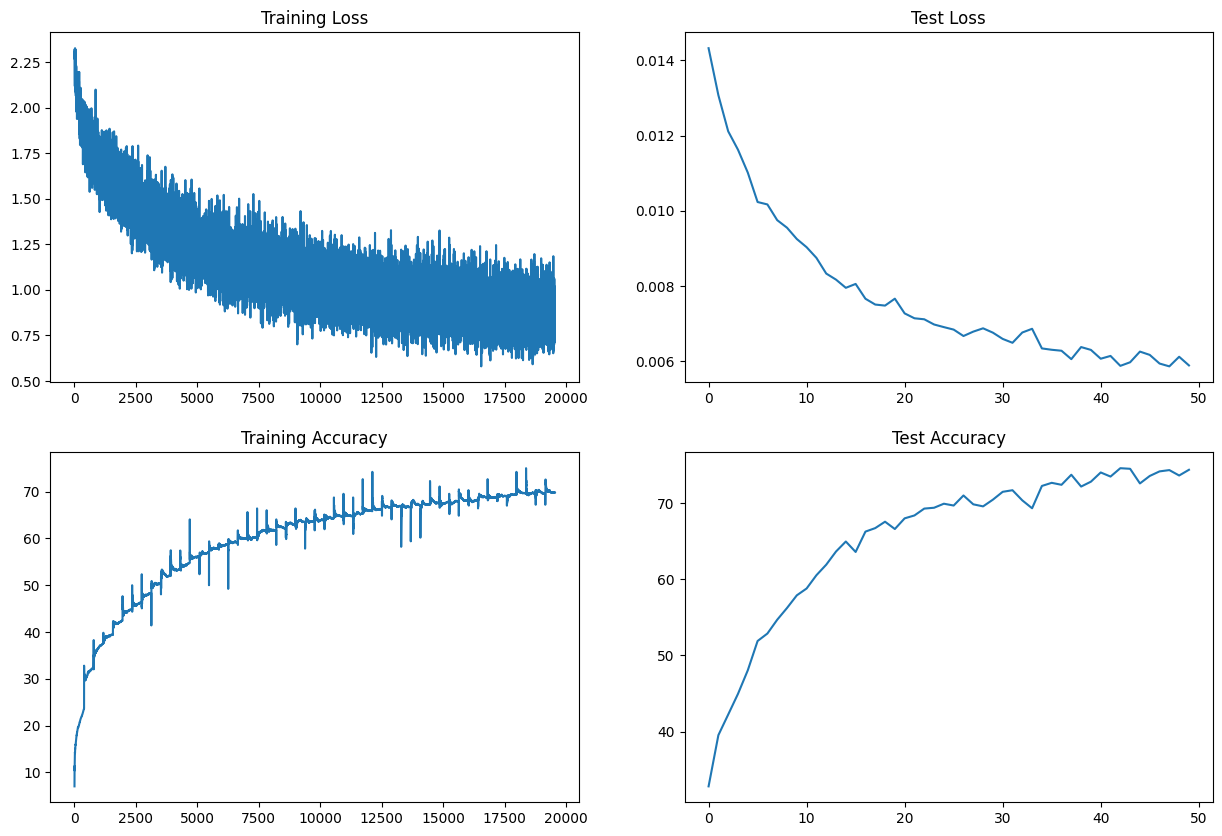

In [18]:
plot_curves(trainer.train_losses,trainer.train_accuracies,tester.test_losses,tester.test_accuracies)

# Model

## normal model ( no conditions apply)

## shrink model  (200k params)

## remove maxpool but 3 conv

## dialated kernels

## depth-wise kernel

## all depth-wise kernel

## apply albumentation